In [1]:
#import
import pandas as pd
import numpy as np
import os
from datetime import datetime

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import warnings
import itertools

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, minmax_scale, QuantileTransformer, RobustScaler, StandardScaler

import sklearn.linear_model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#define
SESSION_PATH = './sessions'
WELLNESS_PATH = './wellness'
PICKLE_PATH = './pickle/'
format = '%Y-%m-%d'

#colonne da shiftare verso l'alto

lista_colonne_workload = [
    'workload-1',
    'workload-2',
#     'workload-3',
#     'workload-4',
#     'workload-5'
                        ]
lista_colonne_rpe = [
    'rpe-1',
    'rpe-2',
#     'rpe-3',
#     'rpe-4',
#     'rpe-5'
]
lista_colonne_Go_score = [
    'Go_score-1',
    'Go_score-2',
#     'Go_score-3',
#     'Go_score-4',
#     'Go_score-5'
]

######################################
lista_category = [
    [lista_colonne_workload,'workload'],
    [lista_colonne_rpe,'rpe'],
    [lista_colonne_Go_score,'Go_score']
]
######################################
#colonne per DNN


#pesi per calcolare GO_Score

SLEEP_PAR = [0.1, 0.1, 0.5, 0.8, 1]
STRESS_PAR = [0.1, 0.1, 1, 1, 1]
FATIGUE_PAR = [0.1, 0.1, 0.5, 0.8, 1]
SORENESS_PAR = [0.1, 0.1, 0.5, 0.8, 1]
MOOD_PAR = [0.1, 0.1, 1, 1, 1]

#script per calcolare nomi colonne
nome = 'Go_score'
n = 5
lista = []
for i in range(-n,0):
    lista.append(nome+str(i))
reversed(lista)

In [3]:
def from_str_to_date(stringa):
    timestr = stringa.split(' ')[0]
    time = datetime.strptime(timestr, format)
    return time

def calcola_go(df):
    try:
        df['Go_score'] = SLEEP_PAR[int(df['wellness_sleep']) - 1] + STRESS_PAR[int(df['wellness_stress']) - 1] + FATIGUE_PAR[int(df['wellness_fatigue']) - 1] + SORENESS_PAR[int(df['wellness_soreness']) - 1] + MOOD_PAR[int(df['wellness_mood']) - 1]   
    except:
        pass
    return df

CREO UN DB CON I DATI DI TUTTI I GIOCATORI, CON COLONNE RIFERITE AI GIORNI PRECEDENTI
===========================

In [4]:
# importo csv associati a ogni player
list_files1 = os.listdir(PICKLE_PATH)
list_file = list_files1.copy()

# tolgo dalla lista dei files quelli non di player
for file in list_files1:
    if 'Player' not in file:
        list_file.remove(file)
    elif 'csv' in file:
        list_file.remove(file)

df_total = pd.DataFrame()
#per ogni file, creo e preparo il db da dare al DNN
for file in list_file:
    print(file)
    player = file.split('.')[0]
    globals()[player] = pd.read_pickle(PICKLE_PATH + file)
    
    #calcolo go score
    df_player = globals()[player].apply(calcola_go, axis=1)

    #drop delle colonne inutili
    df_player = df_player.drop(['exercises','wellness_fatigue','wellness_mood',
                                'wellness_sleep','wellness_soreness','wellness_stress','Work Ratio','rpeTl','duration'], axis=1)
    
    ######################################################################################################
    #faccio le colonne shiftate
    for category in lista_category:
        i = 1
        for column in category[0]:
            df_player[column] = df_player[category[1]].shift(i)
            i += 1

    
    df_player = df_player.dropna(how='any')
    
    globals()[player] = df_player.copy()
    df_total = df_total.append(df_player, ignore_index=True)

#rinomino la colonna Player Load
df_total.rename(columns={'Player Load': 'Player_Load'}, inplace=True)

#creo la colonna previsioni
df_total['Go_score+1'] = df_total['Go_score'].shift(-1)

Player1.pickle
Player10.pickle
Player11.pickle
Player12.pickle
Player13.pickle
Player14.pickle
Player15.pickle
Player16.pickle
Player17.pickle
Player18.pickle
Player19.pickle
Player2.pickle
Player20.pickle
Player21.pickle
Player23.pickle
Player24.pickle
Player25.pickle
Player26.pickle
Player27.pickle
Player28.pickle
Player29.pickle
Player3.pickle
Player30.pickle
Player31.pickle
Player32.pickle
Player4.pickle
Player5.pickle
Player6.pickle
Player7.pickle
Player9.pickle


In [5]:
df_total = df_total.replace([np.inf, -np.inf], np.nan)
df_total = df_total.dropna(how = 'any')
df_total

Go_score  Player_Load  cardioWorkload       date   intensity  \
0          4.4     211.0766             0.0 2017-07-13   52.670960   
1          4.4       0.0000             0.0 2017-07-14    0.000000   
2          3.6       0.0000             0.0 2017-07-15    0.000000   
3          4.4     152.2547             0.0 2017-07-19   30.067697   
4          4.4     321.7572             0.0 2017-07-20   47.980548   
5          4.6     214.3411             0.0 2017-07-21   51.699796   
6          4.4       0.0000             0.0 2017-07-22    0.000000   
7          3.8       0.0000             0.0 2017-07-23    0.000000   
8          4.4     225.7668             0.0 2017-07-24   49.085328   
9          4.4     340.0522             0.0 2017-07-25   51.988453   
10         4.4     265.8620             0.0 2017-07-26   52.918622   
11         4.4       0.0000             0.0 2017-07-27    0.000000   
12         3.5       0.0000             0.0 2017-07-28    0.000000   
13         4.1     259.7995             0.0 2017-07-29   68.170851   
14         4.1       0.0000             0.0 2017-07-30    0.000000   
15         3.0       0.0000             0.0 2017-07-31    0.000000   
16         4.1     245.3810             0.0 2017-08-01   61.300000   
17         4.4     259.6941             0.0 2017-08-02   51.400000   
18         4.4       0.0000             0.0 2017-08-03    0.000000   
19         3.1       0.0000             0.0 2017-08-04    0.000000   
24         4.4     230.8193             0.0 2017-09-26   38.100000   
25         4.4     361.1406             0.0 2017-09-27   54.600000   
26         4.4     213.4038             0.0 2017-09-28   55.000000   
27         4.4       0.0000             0.0 2017-09-29    0.000000   
28         4.4     286.8695             0.0 2017-10-12   31.200000   
29         4.4     230.6958             0.0 2017-10-13   66.300000   
30         4.4       0.0000             0.0 2017-10-14    0.000000   
31         4.0       0.0000             0.0 2017-10-15    0.000000   
32         4.3     214.9808             0.0 2017-10-16   41.200000   
33         4.8     472.0453             0.0 2017-10-17   65.300000   
...        ...          ...             ...        ...         ...   
2878       4.4     290.0276             0.0 2017-11-27   56.099499   
2879       4.6       0.0000             0.0 2017-11-28    0.000000   
2880       4.8      74.3808             0.0 2017-11-29  109.677093   
2881       5.0       0.0000             0.0 2017-11-30    0.000000   
2882       5.0     186.5048             0.0 2017-12-01   42.873566   
2883       5.0       0.0000             0.0 2017-12-02    0.000000   
2884       4.8     186.2664             0.0 2017-12-07   32.341526   
2885       5.0     218.1398             0.0 2017-12-08   53.156393   
2886       5.0     193.4969             0.0 2017-12-09   45.382731   
2887       5.0       0.0000             0.0 2017-12-10    0.000000   
2888       4.8      49.0076             0.0 2017-12-11   85.934839   
2889       4.8     240.9688             0.0 2017-12-12   74.717692   
2890       4.3     127.2441             0.0 2017-12-13   33.398032   
2891       4.5       0.0000             0.0 2017-12-14    0.000000   
2892       4.1       0.0000             0.0 2017-12-15    0.000000   
2893       4.4     480.9758             0.0 2018-01-08   66.800000   
2894       3.8     246.2798             0.0 2018-01-09   39.600000   
2895       4.4     156.3012             0.0 2018-01-13   54.700000   
2896       4.4     317.6268             0.0 2018-01-14   79.000000   
2897       4.6       0.0000             0.0 2018-01-15    0.000000   
2898       4.8     245.1453             0.0 2018-01-16   42.700000   
2899       5.0     426.0186             0.0 2018-01-17  119.400000   
2900       4.8       0.0000             0.0 2018-01-18    0.000000   
2901       5.0     368.0565             0.0 2018-01-19   51.700000   
2902       5.0     188.6155             0.0 2018-01-20   44.800000   
2903       4.6  

In [6]:
df_total.columns.values

array(['Go_score', 'Player_Load', 'cardioWorkload', 'date', 'intensity',
       'kinematicWorkload', 'mechanicalWorkload', 'metabolicWorkload',
       'perceivedWorkload', 'playerName', 'rpe', 'workload', 'workload-1',
       'workload-2', 'rpe-1', 'rpe-2', 'Go_score-1', 'Go_score-2',
       'Go_score+1'], dtype=object)

In [7]:
df_total['Go_score+1'].value_counts()

5.0    903
4.8    516
4.6    403
4.4    399
4.1    136
4.3    106
4.5     76
3.8     75
3.5     54
4.0     40
3.1     26
3.6     18
3.4     15
2.7     14
3.7     10
3.0     10
3.9      7
0.5      5
3.9      5
3.2      5
3.4      5
1.8      3
2.1      2
1.4      2
2.6      1
2.3      1
2.0      1
3.7      1
2.2      1
1.8      1
0.9      1
Name: Go_score+1, dtype: int64

RETE NEURALE 
============================

In [24]:
#define
OUTPUT = 'Go_score+1'
EPOCHS = 1000
HIDDEN_UNITS = [1000]

In [25]:
#drop colonne inutili
train = df_total.drop(['date','playerName','cardioWorkload','intensity','Player_Load','rpe',
                      'perceivedWorkload' #contiene dati da rpe e quindi è soggettivo
                      ],axis = 1)

#drop dati a 0
train = train[train['workload']!=0]

#droppo colonne con parametri go troppo bassi
colonne_go = ['Go_score']+lista_colonne_Go_score+[OUTPUT]
        
for colonna in colonne_go:
    train = train[train[colonna]>= 2]

# #muovo go_score+1 in fondo
# serie = train[OUTPUT]
# train = train.drop([OUTPUT],axis=1)
# train[OUTPUT] = serie

input_dataset = train.copy()
train

Go_score  kinematicWorkload  mechanicalWorkload  metabolicWorkload  \
0          4.4          24.214674           76.465862          32.792852   
3          4.4          11.966843           16.576010           3.261364   
4          4.4          40.598923           92.190335          38.251649   
5          4.6          22.170423           60.547669          21.337968   
8          4.4          27.541671           82.128345          32.950441   
9          4.4          31.970858           83.537039          34.866956   
10         4.4          27.033579           75.438689          30.615362   
13         4.1          29.290067           88.929037          35.330247   
16         4.1          25.900000           41.900000          34.500000   
17         4.4          20.800000           30.000000          20.500000   
24         4.4          18.200000           36.600000          13.500000   
25         4.4          34.700000           96.000000          37.300000   
26         4.4          23.100000           80.200000          32.500000   
28         4.4          20.500000           38.800000          16.700000   
29         4.4          31.000000           74.700000          31.800000   
32         4.3          55.200000           37.500000          32.300000   
33         4.8          74.800000          171.500000          76.000000   
34         4.1          22.700000           70.600000          25.000000   
35         4.4          12.900000           25.700000           8.400000   
36         4.4          54.100000           76.300000          45.900000   
39         4.1          33.900000           80.900000          40.600000   
40         4.4          78.200000          107.700000          71.100000   
41         4.4          13.900000           29.500000           8.500000   
42         4.4          21.100000           69.600000          23.200000   
45         3.8          11.393546           17.716882           6.499672   
46         4.4           0.000000           78.471437          23.353869   
50         4.6          30.655438           61.724013          24.313152   
52         3.7           0.000000           30.667909           0.000000   
53         4.6          30.149023           49.779435          18.703567   
54         4.4          35.058195           60.833624          21.781589   
...        ...                ...                 ...                ...   
2864       4.8          31.000000           52.100000          32.800000   
2866       3.8           0.000000           17.400000           5.200000   
2867       4.8           0.000000           75.000000          20.900000   
2868       5.0           0.000000           69.900000          29.100000   
2871       4.3          66.200000           57.700000          54.300000   
2872       4.4          97.100000          131.600000          87.700000   
2873       4.3          14.700000           55.900000          11.400000   
2874       4.8           0.000000           58.900000          24.400000   
2877       3.5           0.000000           12.286013           3.313040   
2878       4.4          26.212381           80.415551          23.424680   
2880       4.8           0.000000           56.503058          26.613510   
2882       5.0          20.816713           54.914352          18.110013   
2884       4.8           0.000000           32.035344           5.281493   
2885       5.0          40.719182           52.041541          20.947768   
2886       5.0          49.656688           46.493865          20.202312   
2888       4.8          43.867459           30.285221          20.597855   
2889       4.8          83.624732           69.818279          69.283985   
2890       4.3           0.000000           40.025110          16.890945   
2893       4.4         124.500000          169.800000         106.900000   
2894       3.8          30.900000          102.600000          45.600000   
2895       4.4          22.900000           36.200000 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\LucaC\\AppData\\Local\\Temp\\tmpcul7qafq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001C5515AF8D0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\LucaC\\AppData\\Local\\Temp\\tmpqqv67cml', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_eve

Exception ignored in: <generator object Estimator.predict at 0x000001C54F2789E8>
Traceback (most recent call last):
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 511, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 5086, in get_controller
    yield g
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 4904, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\LucaC\AppData\Local\Temp\tmpcul7qafq\model.ckpt-13
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.


Exception ignored in: <generator object Estimator.predict at 0x000001C550985AF0>
Traceback (most recent call last):
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 511, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 5086, in get_controller
    yield g
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 4904, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\LucaC\AppData\Local\Temp\tmpqqv67cml\model.ckpt-13
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


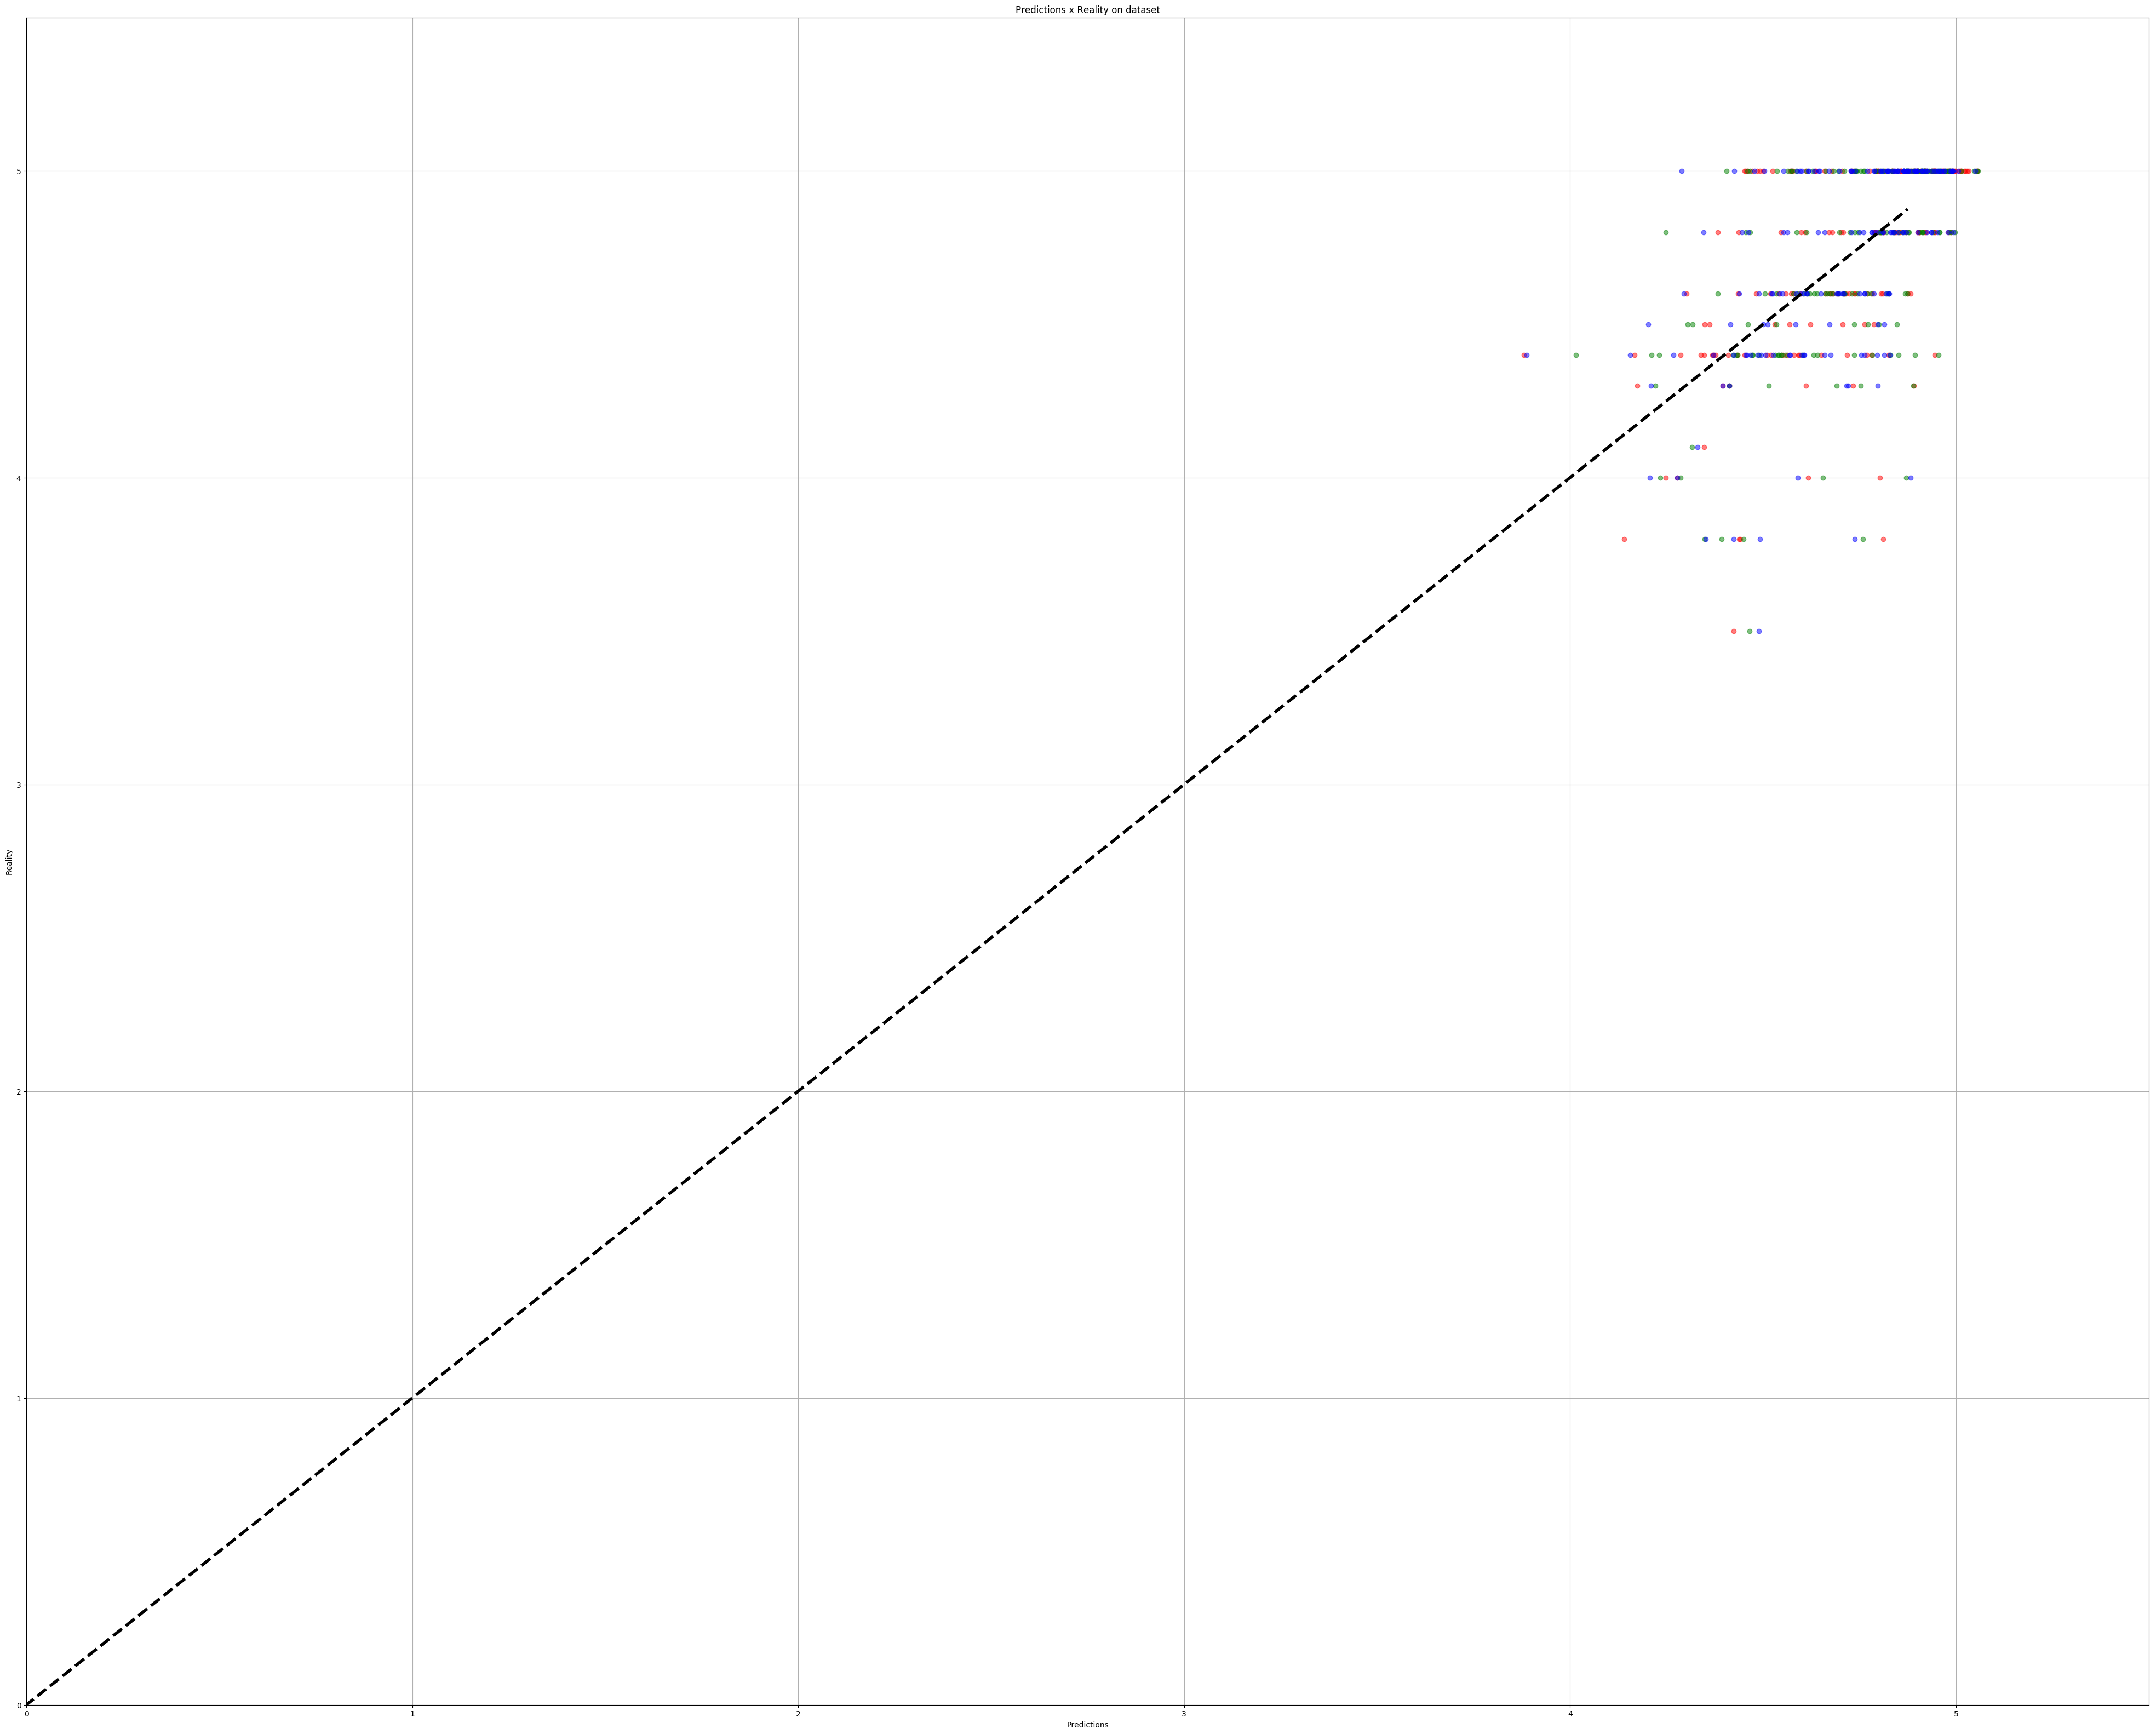

In [26]:
# Isolate outliers with an IsolationForest algorithm


'''clf = IsolationForest(max_samples=1000, random_state=42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns=['Top'])
y_noano[y_noano['Top'] == 1].index.values
train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop=True, inplace=True)
print('')
print('Number of Outliers:', y_noano[y_noano['Top'] == -1].shape[0])
print('Number of rows without outliers:', train.shape[0])'''


# Preprocessing dataset with MinMaxScale function

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove(OUTPUT)

# mat_train = np.matrix(train)
# #mat_input = np.matrix(input_dataset)
# mat_new = np.matrix(train.drop(OUTPUT, axis=1))
# mat_y = np.array(train[OUTPUT].reshape((train.shape[0], 1)))

# prepro_y = MinMaxScaler()
# prepro_y.fit(mat_y)

# prepro = MinMaxScaler()
# prepro.fit(mat_train)

# prepro_input = MinMaxScaler()
# prepro_input.fit(mat_new)

mat_train = train.copy()
# prepro = MinMaxScaler(copy=True, feature_range=(0, 1))
# prepro = QuantileTransformer(ignore_implicit_zeros=True)
# prepro = RobustScaler()
prepro = StandardScaler(copy=True, with_mean=True, with_std=True)

# prepro_y = MinMaxScaler(copy=True, feature_range=(0, 1))
# prepro_y = QuantileTransformer(ignore_implicit_zeros=True)
# prepro_y = RobustScaler()
prepro_y = StandardScaler(copy=True, with_mean=True, with_std=True)

mat_y = prepro_y.fit_transform(train[OUTPUT].values.reshape(-1,1))

train = pd.DataFrame(prepro.fit_transform(mat_train), columns=col_train)

#input_dataset = pd.DataFrame(prepro_input.transform(mat_input), columns=col_train_bis)

# TensorFlow deep neural network

# List of features

COLUMNS = col_train
FEATURES = col_train_bis

# Columns for tensorflow

feature_cols = [tf.contrib.layers.real_valued_column(k) for k in FEATURES]

# Training set and Prediction set with the features to predict

training_set = train[COLUMNS]
prediction_set = train[OUTPUT]

# Train and Test split


x_train, x_test, y_train, y_test = train_test_split(training_set[FEATURES], prediction_set, test_size=0.1, random_state=42)
y_train = pd.DataFrame(y_train, columns=[OUTPUT])
training_set = pd.DataFrame(x_train, columns=FEATURES).merge(y_train, left_index=True, right_index=True)


# Training for submission


training_sub = training_set[col_train]
y_test = pd.DataFrame(y_test, columns=[OUTPUT])
testing_set = pd.DataFrame(x_test, columns=FEATURES).merge(y_test, left_index=True, right_index=True)


# Model

tf.logging.set_verbosity(tf.logging.INFO)
regressor = tf.estimator.DNNRegressor(hidden_units= HIDDEN_UNITS, 
                                      feature_columns=feature_cols, 
                                      model_dir=None,
                                      label_dimension=1,
                                      weight_column=None,
                                      optimizer = tf.train.AdamOptimizer(learning_rate=0.001),
#                                       optimizer=tf.train.ProximalAdagradOptimizer(
#                                                                                   learning_rate=0.001,
#                                                                                   l1_regularization_strength=0.001
#                                                                                   ),
                                      activation_fn=tf.nn.relu,
                                      dropout=0.3,
                                      input_layer_partitioner=None,
                                      config=None,
                                      warm_start_from=None,
                                      loss_reduction= tf.losses.Reduction.SUM
                                     )

linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_cols)

lr_sklearn = sklearn.linear_model.LinearRegression(fit_intercept=False, copy_X=True, n_jobs=-1)

# Reset the index of training

training_set.reset_index(drop=True, inplace=True)

# Deep Neural Network Regressor with the training set which contain the data split by train test split

regressor.train(input_fn=tf.estimator.inputs.pandas_input_fn(x = training_set, y = training_set[OUTPUT], 
                                                             shuffle=False), steps=EPOCHS)

linear_regressor.train(input_fn=tf.estimator.inputs.pandas_input_fn(x = training_set, y = training_set[OUTPUT], 
                                                             shuffle=False))

lr_sklearn.fit(np.matrix(training_set.drop([OUTPUT], axis=1)),np.array(training_set[OUTPUT].values.reshape((training_set.shape[0], 1))))

# # Evaluation on the test set created by train_test_split


# ev = regressor.evaluate(input_fn=tf.estimator.inputs.pandas_input_fn(x = testing_set,y = testing_set[OUTPUT],
#                                                                          shuffle=False), steps=1)


# # Display the score on the testing set


# loss_score1 = ev['loss']
# print('')
# print('Final Loss on the testing set: {0:f}'.format(loss_score1))
# print('')

# Predictions on testing set


y = regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(testing_set, shuffle=False))
predictions1 = list(itertools.islice(y, testing_set.shape[0]))

linear_y = linear_regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(testing_set, shuffle=False))
linear_predictions1 = list(itertools.islice(linear_y, testing_set.shape[0]))

lr_sklearn_y = lr_sklearn.predict(np.matrix(testing_set.drop([OUTPUT], axis=1)))

#inverse transformation of data

try:
    predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in predictions1]).reshape(len(x_test), 1))
    reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns=[COLUMNS])[OUTPUT].values
except:
    predictions = (np.array([x['predictions'] for x in predictions1]).reshape(len(x_test), 1))
    reality = np.array((testing_set)[OUTPUT].values).reshape(len(x_test), 1)

try:
    linear_predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in linear_predictions1]).reshape(len(x_test), 1))
    linear_reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns=[COLUMNS])[OUTPUT].values
except:
    linear_predictions = (np.array([x['predictions'] for x in linear_predictions1]).reshape(len(x_test), 1))
    linear_reality = np.array((testing_set)[OUTPUT].values).reshape(len(x_test), 1)

lr_sklearn_predictions = prepro_y.inverse_transform(lr_sklearn_y)
lr_sklearn_reality = linear_reality = pd.DataFrame(prepro.inverse_transform(testing_set), columns=[COLUMNS])[OUTPUT].values

# Plot predictions x reality on dataset graph
    
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([0, 5.5])
axes.set_ylim([0, 5.5])
plt.style.use('default')
plt.plot(predictions, reality, 'ro', color='red',alpha = 0.5)
plt.plot(linear_predictions, linear_reality, 'ro', color='green',alpha = 0.5)
plt.plot(lr_sklearn_predictions, lr_sklearn_reality, 'ro', color='blue',alpha = 0.5)
plt.xlabel('Predictions')
plt.ylabel('Reality')
plt.title('Predictions x Reality on dataset')
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()

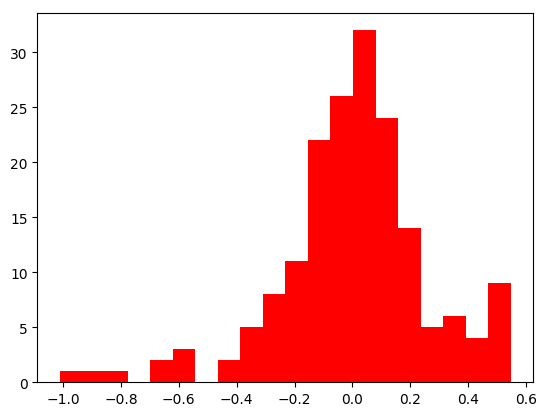

In [27]:
error = []
for x in (reality) - predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20,color='red') # plotting by columns
plt.show()

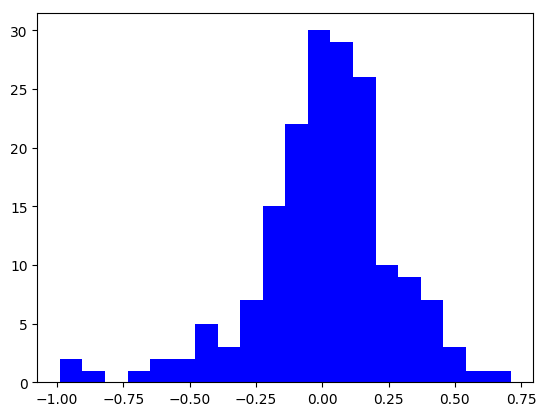

0.3094720034559373


In [28]:
error = []
for x in (lr_sklearn_reality) - lr_sklearn_predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20, color='blue') # plotting by columns
plt.show()

print(lr_sklearn.score(np.matrix(testing_set.drop([OUTPUT], axis=1)),
                       np.array(testing_set[OUTPUT].values.reshape((testing_set.shape[0], 1)))))

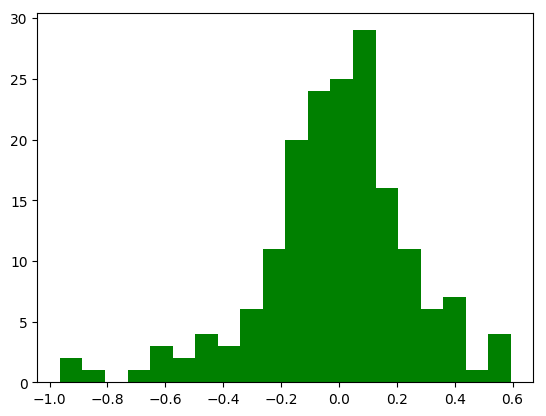

In [29]:
error = []
for x in (linear_reality) - linear_predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20, color='green') # plotting by columns
plt.show()

INFO:tensorflow:Calling model_fn.


Exception ignored in: <generator object Estimator.predict at 0x000001C550E93A98>
Traceback (most recent call last):
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 511, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 5086, in get_controller
    yield g
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 4904, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\LucaC\AppData\Local\Temp\tmpcul7qafq\model.ckpt-13
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


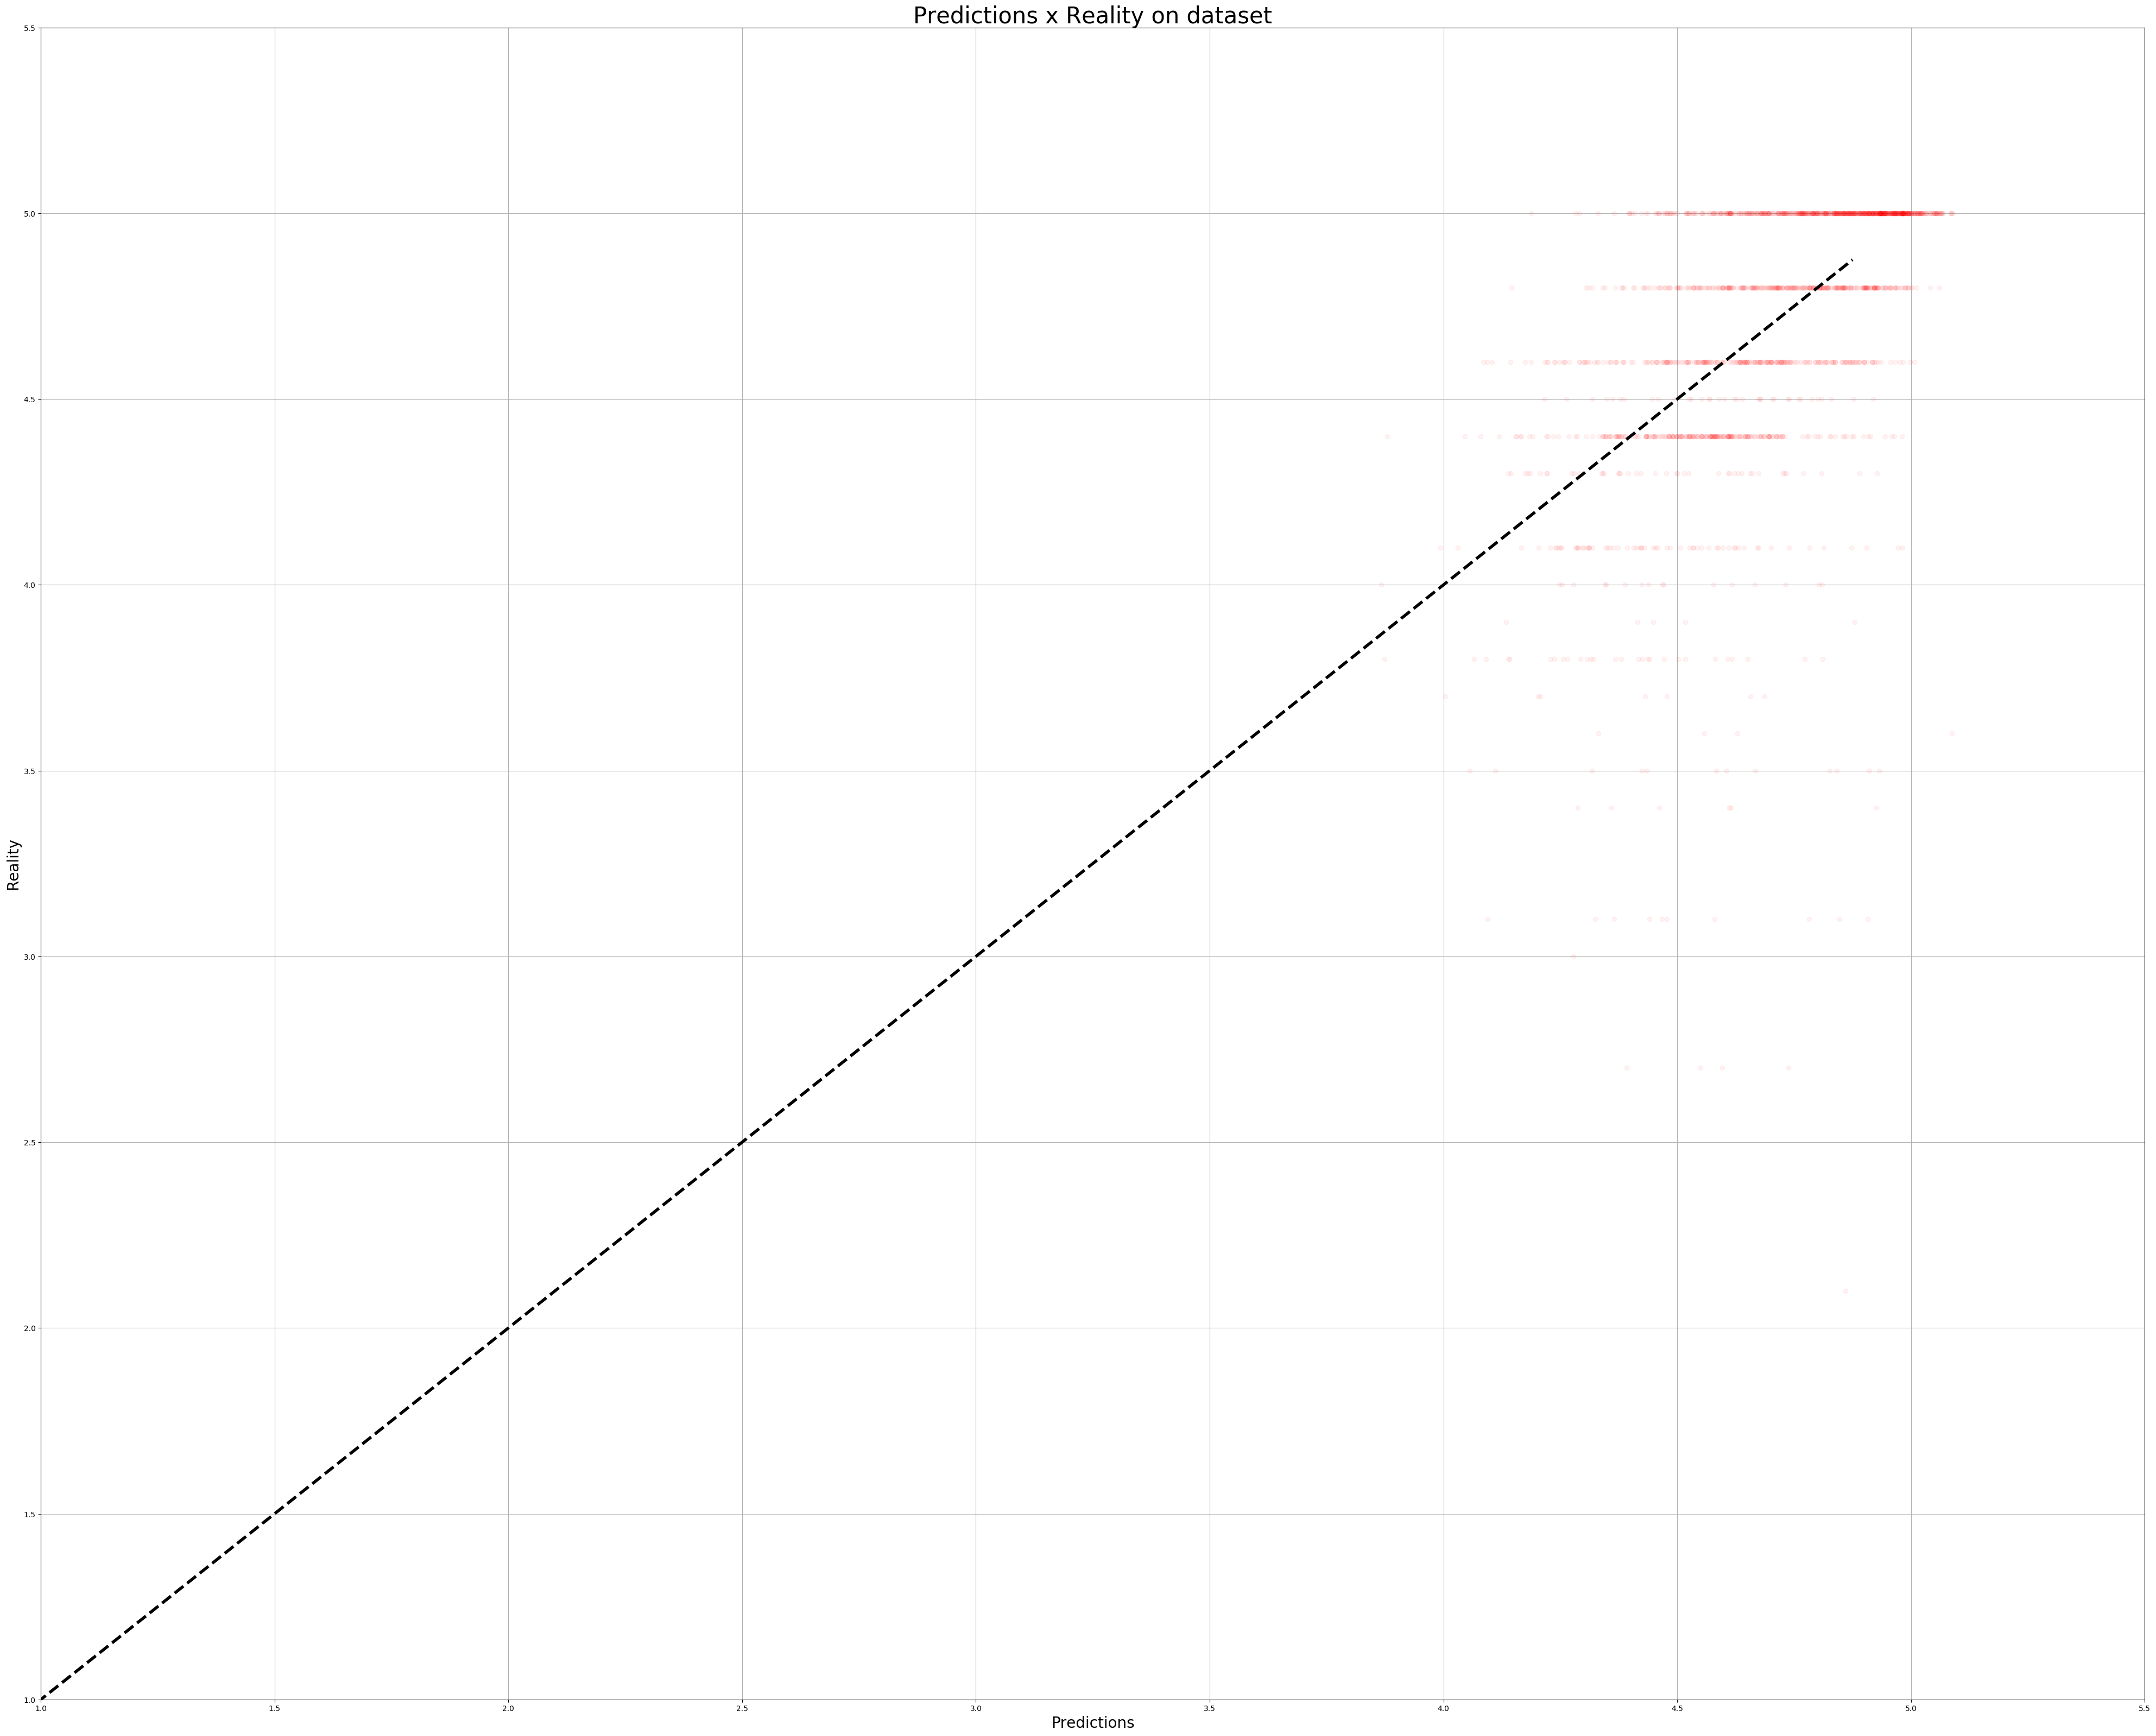

In [30]:
y = regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(train.drop([OUTPUT],axis = 1), shuffle=False))
predictions = list(itertools.islice(y, train.shape[0]))

# Plot predictions x reality on dataset graph


predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in predictions]).reshape(-1, 1))
reality = pd.DataFrame(prepro.inverse_transform(train), columns=[COLUMNS])[OUTPUT].values
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([1, 5.5])
axes.set_ylim([1, 5.5])
plt.style.use('default')
plt.plot(predictions, reality, 'ro', color='red',alpha = 0.05)
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Reality', fontsize=20)
plt.title('Predictions x Reality on dataset', fontsize=30)
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()

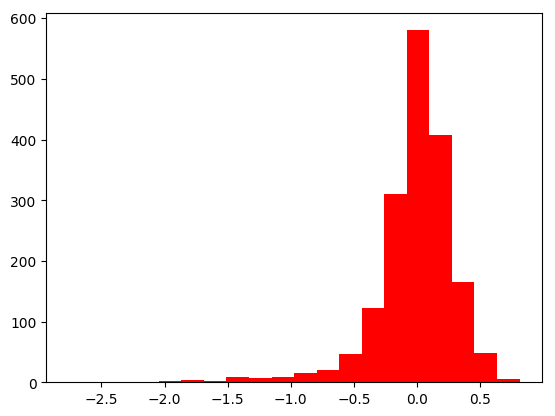

In [31]:
error = []
for x in (reality) - predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20,color='red') # plotting by columns
plt.show()

INFO:tensorflow:Calling model_fn.


Exception ignored in: <generator object Estimator.predict at 0x000001C551523830>
Traceback (most recent call last):
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\estimator\estimator.py", line 511, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 5086, in get_controller
    yield g
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\ops.py", line 4904, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\LucaC\AppData\Local\Temp\tmpqqv67cml\model.ckpt-13
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


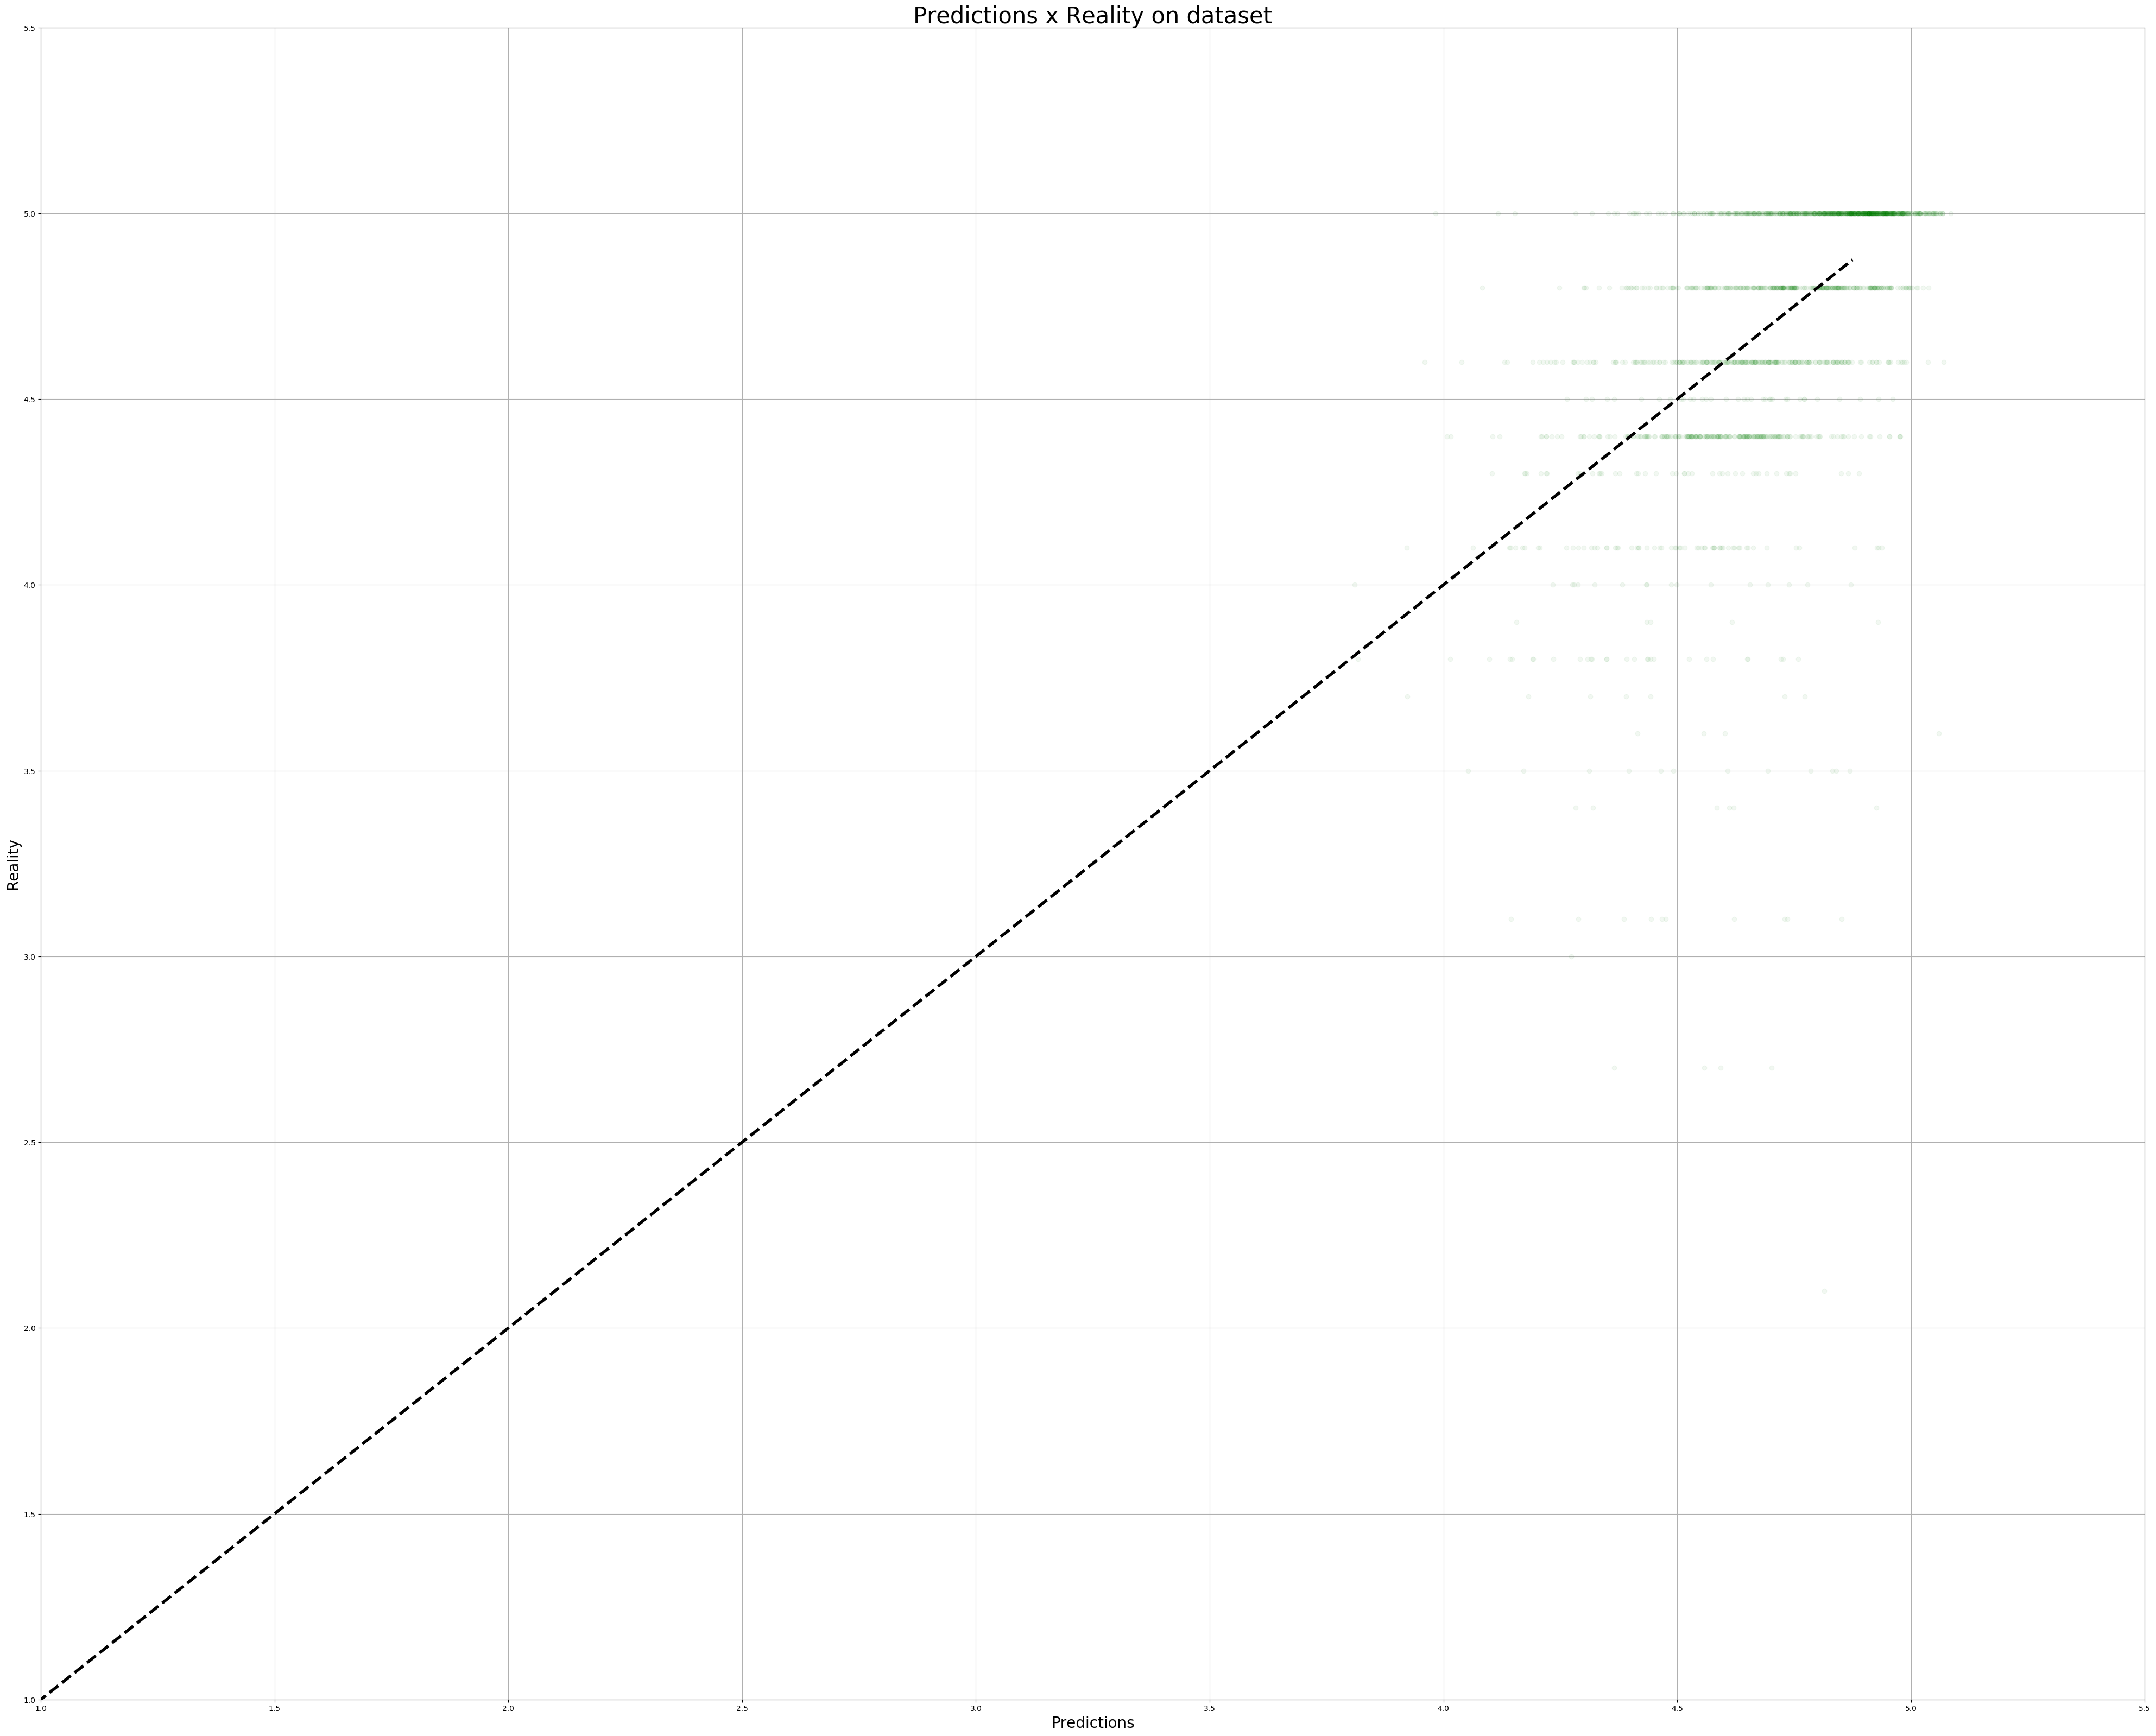

In [32]:
linear_y = linear_regressor.predict(input_fn=tf.estimator.inputs.pandas_input_fn(train.drop([OUTPUT],axis = 1), shuffle=False))
linear_predictions = list(itertools.islice(linear_y, train.shape[0]))

# Plot predictions x reality on dataset graph


linear_predictions = prepro_y.inverse_transform(np.array([x['predictions'] for x in linear_predictions]).reshape(-1, 1))
linear_reality = pd.DataFrame(prepro.inverse_transform(train), columns=[COLUMNS])[OUTPUT].values
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([1, 5.5])
axes.set_ylim([1, 5.5])
plt.style.use('default')
plt.plot(linear_predictions, linear_reality, 'ro', color='green',alpha = 0.05)
plt.xlabel('Predictions', fontsize=20)
plt.ylabel('Reality', fontsize=20)
plt.title('Predictions x Reality on dataset', fontsize=30)
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()

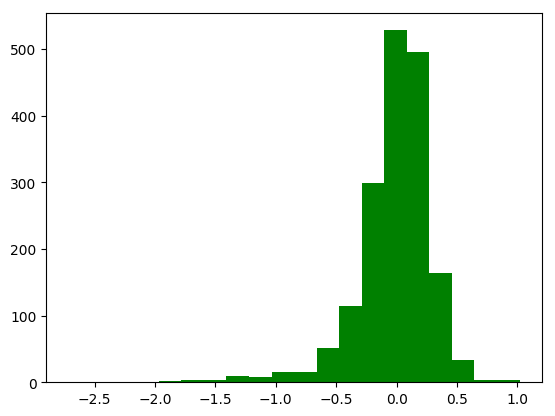

In [33]:
error = []
for x in linear_reality - linear_predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20,color='green') # plotting by columns
plt.show()

c:\users\lucac\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


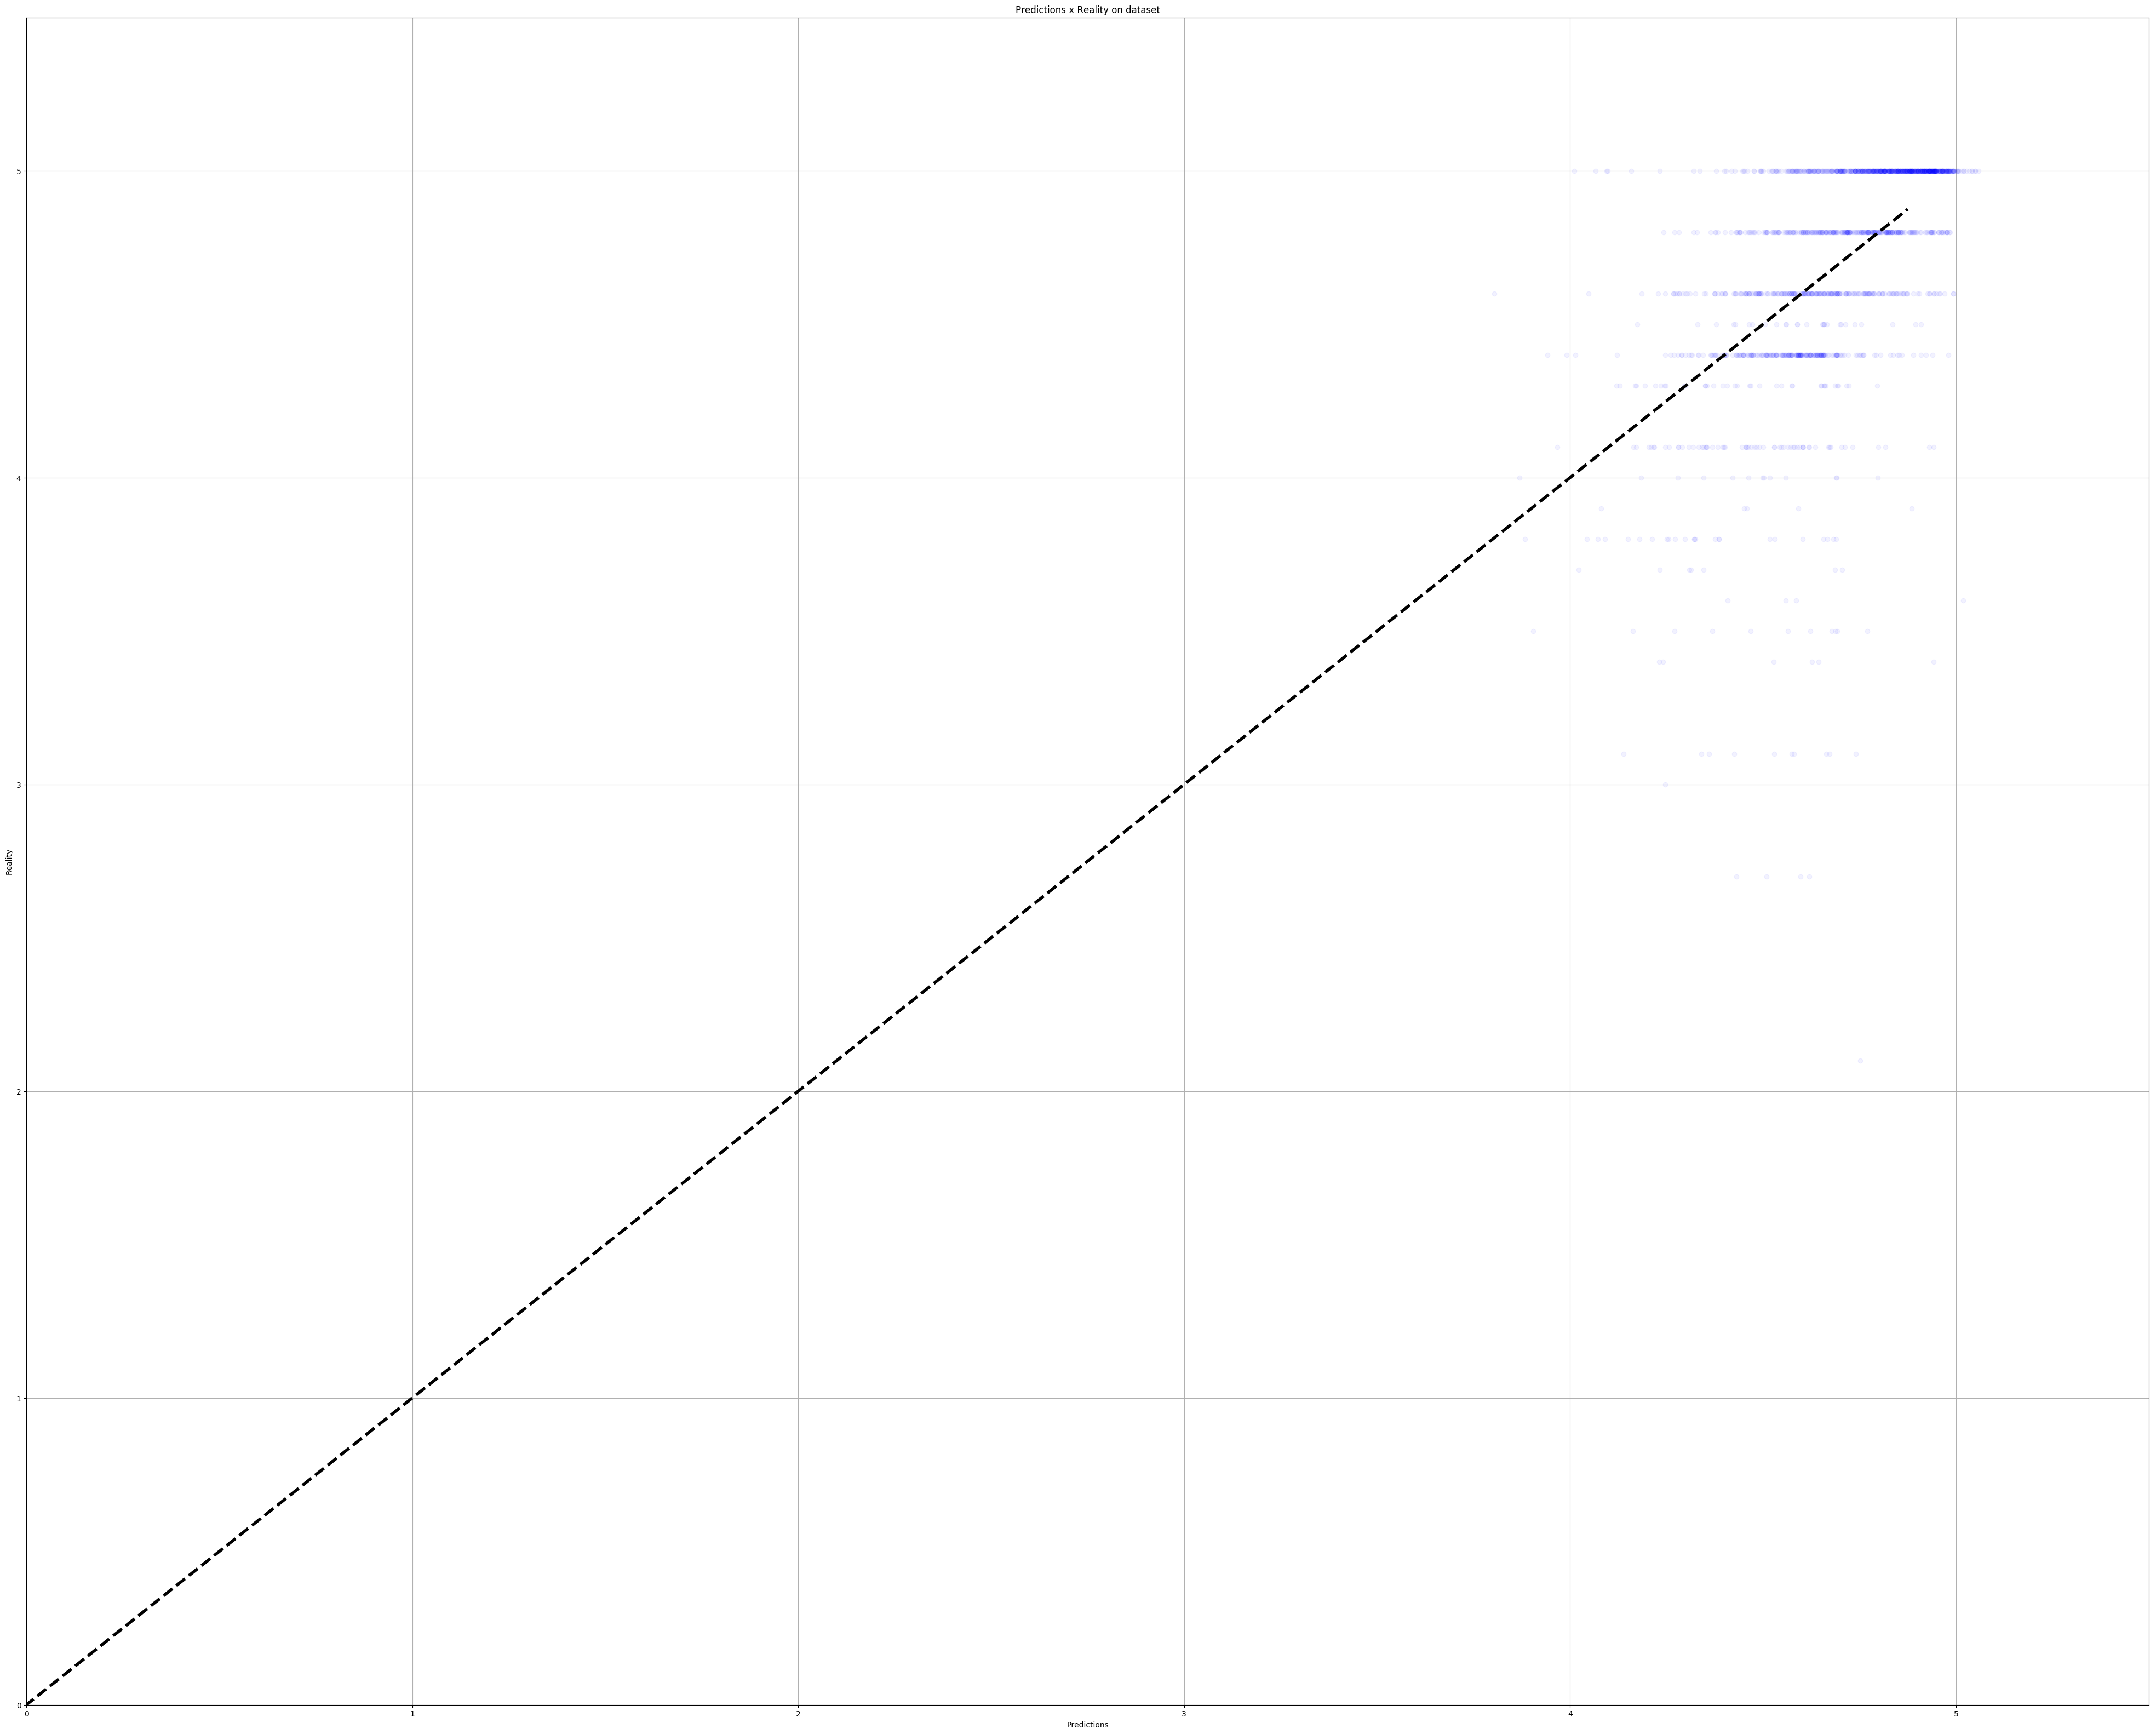

In [34]:
lr_sklearn_y = lr_sklearn.predict(np.matrix(training_set.drop([OUTPUT], axis=1)))

lr_sklearn_predictions = prepro_y.inverse_transform(lr_sklearn_y)
lr_sklearn_reality = pd.DataFrame(prepro.inverse_transform(training_set), columns=[COLUMNS])[OUTPUT].values

# Plot predictions x reality on dataset graph
    
font = {'family' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(50, 40))
axes = plt.gca()
axes.set_xlim([0, 5.5])
axes.set_ylim([0, 5.5])
plt.style.use('default')
plt.plot(lr_sklearn_predictions, lr_sklearn_reality, 'ro', color='blue',alpha = 0.05)
plt.xlabel('Predictions')
plt.ylabel('Reality')
plt.title('Predictions x Reality on dataset')
ax.grid()
ax.plot([-1, 4.875], [-1, 4.875], 'k--', lw=4)
plt.show()

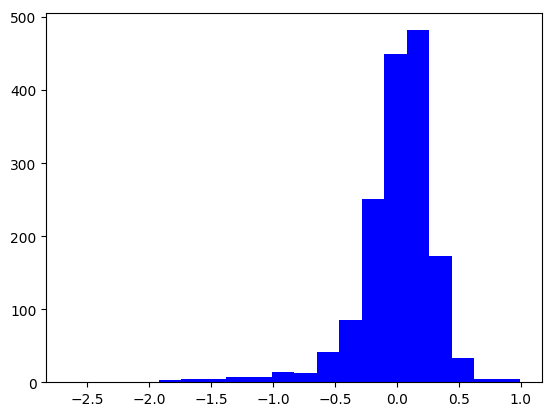

In [35]:
error = []
for x in (lr_sklearn_reality) - lr_sklearn_predictions:
    error.append((float(x)))
error.sort()

plt.hist(error,bins = 20, color='blue') # plotting by columns
plt.show()

In [36]:
lista_colonne_json = list(train.columns.values)
scale_df = pd.DataFrame(columns= lista_colonne_json)
scale_df.loc[1] = prepro.mean_
scale_df.loc[2] = prepro.var_

lista_colonne_json.remove(OUTPUT)

df_coeff = pd.DataFrame(lr_sklearn.coef_, columns = lista_colonne_json)

scale_df = scale_df.append(df_coeff)
scale_df.to_json('Standardizzazione.txt',orient='records')
scale_df

Go_score  Go_score+1  Go_score-1  Go_score-2  kinematicWorkload  \
1  4.665849    4.689396    4.533979    4.551482          30.437893   
2  0.105863    0.140081    0.215071    0.222201         695.344869   
0  0.409952         NaN    0.014168    0.081445          -0.066464   

   mechanicalWorkload  metabolicWorkload     rpe-1     rpe-2  workload  \
1           54.362589          34.254699  2.457526  2.536488  2.192852   
2         1878.746656         693.503390  3.857232  5.722443  1.903914   
0            0.268703           0.192745  0.041695 -0.106954 -0.684362   

   workload-1  workload-2  
1    1.632314    1.674456  
2    2.303182    3.071895  
0   -0.020574    0.074940

In [37]:
df_total_temp = df_total.drop(['cardioWorkload','date','intensity','rpe','metabolicWorkload','workload',
                               'Player_Load','kinematicWorkload','mechanicalWorkload','perceivedWorkload','Go_score+1'
                              ], 
                              axis = 1)

player_list = df_total_temp['playerName'].unique()

new_df = pd.DataFrame()
for player in player_list:
    new_df = new_df.append(df_total_temp[df_total_temp['playerName'].isin([player])].sample(n=1))
    
new_df = new_df.reset_index(drop=True)
new_df.to_json('Giocatori.txt',orient='records')
new_df

Go_score playerName  workload-1  workload-2  rpe-1  rpe-2  Go_score-1  \
0        4.1    Player1    0.000000    0.000000    0.0    0.0         3.4   
1        5.0   Player10    0.000000    2.026795    0.0    5.0         5.0   
2        3.9   Player11    0.000000    0.000000    0.0    0.0         3.9   
3        5.0   Player12    2.300000    1.200000    3.0    1.0         5.0   
4        5.0   Player13    1.600000    0.000000    4.0    0.0         5.0   
5        5.0   Player14    1.574306    1.811739    2.0    3.0         5.0   
6        4.4   Player15    0.000000    6.400000    0.0   11.0         4.5   
7        5.0   Player16    0.000000    2.700000    0.0    6.0         4.3   
8        5.0   Player17    0.952816    0.000000    3.0    0.0         4.8   
9        4.6   Player18    2.000000    0.000000    0.0    0.0         4.8   
10       3.9   Player19    0.000000    1.500000    0.0    3.0         5.0   
11       4.6    Player2    2.600000    1.400000    3.0    3.0         4.4   
12       4.6   Player20    9.800000    2.000000    9.5    3.0         4.8   
13       4.4   Player21    0.000000    0.000000    0.0    0.0         4.4   
14       4.0   Player23    0.000000    2.900000    0.0    0.0         4.5   
15       4.8   Player24    0.000000    0.000000    0.0    0.0         5.0   
16       4.5   Player25    0.000000    2.800000    4.0    5.0         4.4   
17       4.4   Player26    3.400000    2.800000    9.0    0.0         4.4   
18       4.6   Player27    1.000000    0.000000    3.0    0.0         4.4   
19       5.0   Player28    0.800000    2.300000    0.5    5.0         4.6   
20       4.4   Player29    1.400000    0.000000    2.0    0.0         4.4   
21       4.4    Player3    2.100000    0.000000    3.0    0.0         4.4   
22       4.1   Player30    6.100000    2.600000   10.0    2.0         4.8   
23       4.6   Player31    1.400000    4.600000    2.5    5.0         4.4   
24       4.8   Player32    0.000000    0.000000    0.0    0.0         3.8   
25       4.1    Player4    3.300000    2.300000    8.0    0.0         4.4   
26       4.8    Player5    2.200000    3.300000    4.0    4.0         4.6   
27       5.0    Player6    3.400000    0.000000    8.0    0.0         4.6   
28       4.4    Player7    1.719708    1.474944    3.0    5.0         4.8   
29       2.7    Player9    0.000000    1.900000    0.0    2.0         4.5   

    Go_score-2  
0          4.4  
1          5.0  
2          4.1  
3          4.1  
4          4.8  
5          4.8  
6          4.4  
7          4.8  
8          4.8  
9          4.8  
10         5.0  
11         4.1  
12         4.8  
13         4.1  
14         4.6  
15         5.0  
16         4.8  
17         4.8  
18         4.1  
19         4.6  
20         4.1  
21         3.8  
22         4.8  
23         4.8  
24         5.0  
25         4.4  
26         4.6  
27         3.8  
28         4.6  
29         4.8

In [22]:
linear_regressor.get_variable_names()

['global_step',
 'linear/linear_model/Go_score-1/weights',
 'linear/linear_model/Go_score-1/weights/part_0/Ftrl',
 'linear/linear_model/Go_score-1/weights/part_0/Ftrl_1',
 'linear/linear_model/Go_score-2/weights',
 'linear/linear_model/Go_score-2/weights/part_0/Ftrl',
 'linear/linear_model/Go_score-2/weights/part_0/Ftrl_1',
 'linear/linear_model/Go_score/weights',
 'linear/linear_model/Go_score/weights/part_0/Ftrl',
 'linear/linear_model/Go_score/weights/part_0/Ftrl_1',
 'linear/linear_model/bias_weights',
 'linear/linear_model/bias_weights/part_0/Ftrl',
 'linear/linear_model/bias_weights/part_0/Ftrl_1',
 'linear/linear_model/kinematicWorkload/weights',
 'linear/linear_model/kinematicWorkload/weights/part_0/Ftrl',
 'linear/linear_model/kinematicWorkload/weights/part_0/Ftrl_1',
 'linear/linear_model/mechanicalWorkload/weights',
 'linear/linear_model/mechanicalWorkload/weights/part_0/Ftrl',
 'linear/linear_model/mechanicalWorkload/weights/part_0/Ftrl_1',
 'linear/linear_model/metabolicWo

In [23]:
for x in linear_regressor.get_variable_names():
    print(x)
    print(linear_regressor.get_variable_value(x))
    print('\n')

global_step
13


linear/linear_model/Go_score-1/weights
[[0.00422027]]


linear/linear_model/Go_score-1/weights/part_0/Ftrl
[[13526.888]]


linear/linear_model/Go_score-1/weights/part_0/Ftrl_1
[[-2.4541962]]


linear/linear_model/Go_score-2/weights
[[0.0391296]]


linear/linear_model/Go_score-2/weights/part_0/Ftrl
[[8803.856]]


linear/linear_model/Go_score-2/weights/part_0/Ftrl_1
[[-18.357428]]


linear/linear_model/Go_score/weights
[[0.41045666]]


linear/linear_model/Go_score/weights/part_0/Ftrl
[[9475.042]]


linear/linear_model/Go_score/weights/part_0/Ftrl_1
[[-199.76889]]


linear/linear_model/bias_weights
[0.05999465]


linear/linear_model/bias_weights/part_0/Ftrl
[7284.2563]


linear/linear_model/bias_weights/part_0/Ftrl_1
[-25.602074]


linear/linear_model/kinematicWorkload/weights
[[-0.07204197]]


linear/linear_model/kinematicWorkload/weights/part_0/Ftrl
[[31502.832]]


linear/linear_model/kinematicWorkload/weights/part_0/Ftrl_1
[[63.933773]]


linear/linear_model/mechanical